In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pprint

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def transformImage(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    docCnt = None
    if len(cnts) > 0:
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                docCnt = approx
                break
                
    warped = four_point_transform(img, docCnt.reshape(4, 2))
    return warped

def detectAnswers(img, ans_threshold=15000, question=10, min_countour=1500, rows_distance=50):
    answ_dict = {0: "A", 1: "B", 2: "C", 3: "D"}
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    current_x = np.inf
    answers = {}
    marks_in_row = []
    for c in contours:
        if cv2.contourArea(c) < min_countour:
            continue
        y,x,w,h = cv2.boundingRect(c)
        if np.isinf(current_x):
            current_x = x
            
        if np.abs(x - current_x) > rows_distance:
            marks_in_row.sort(key=lambda elem: elem[0])
            valid = (np.argwhere(np.array(marks_in_row[-4:])[:, 1] > ans_threshold))
            answers[question] = list(map(answ_dict.get, valid.flatten().tolist()))
            question -= 1
            current_x = x
            marks_in_row = []
        marks_in_row.append((y, np.sum(img[x:x+h, y:y+w] == 255)))
    return answers

In [2]:
img1 = cv2.imread("20220421_152418.jpg", 0)
img2 = cv2.imread("20220421_152433.jpg", 0)
img3 = cv2.imread("20220421_152444.jpg", 0)
img4 = cv2.imread("20220421_152501.jpg", 0)


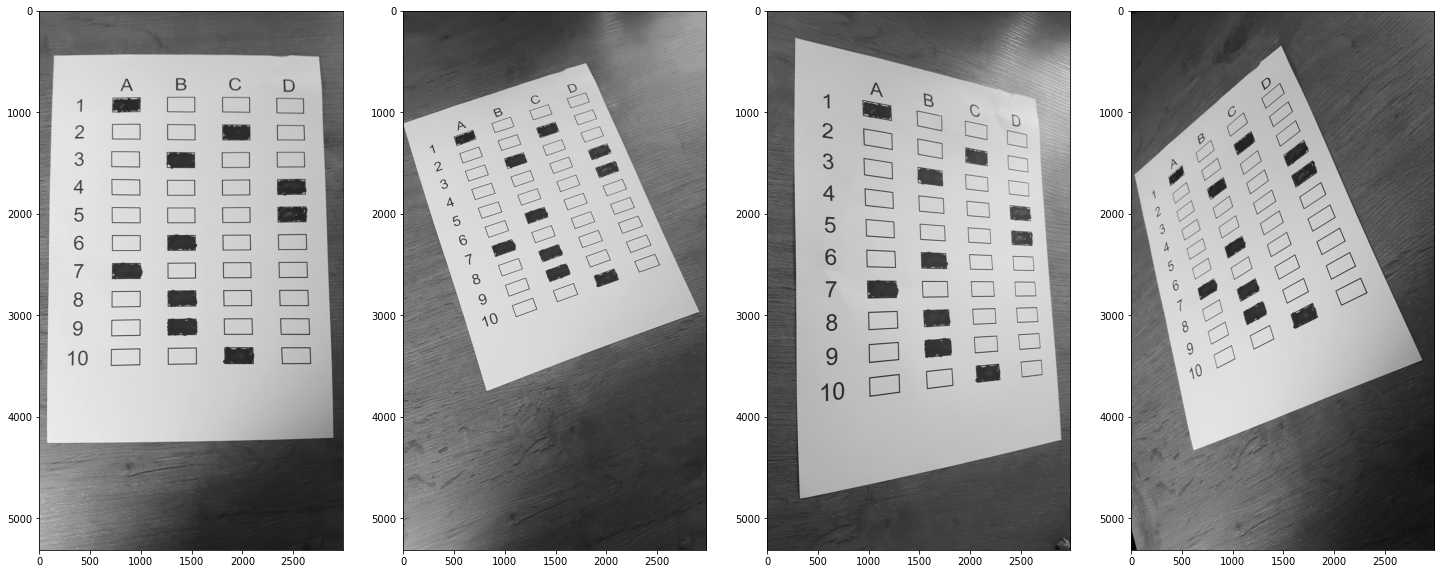

In [3]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(141)
plt.imshow(img1, cmap="gray")
plt.subplot(142)
plt.imshow(img2, cmap="gray")
plt.subplot(143)
plt.imshow(img3, cmap="gray")
plt.subplot(144)
plt.imshow(img4, cmap="gray")
plt.show()

# Transformation

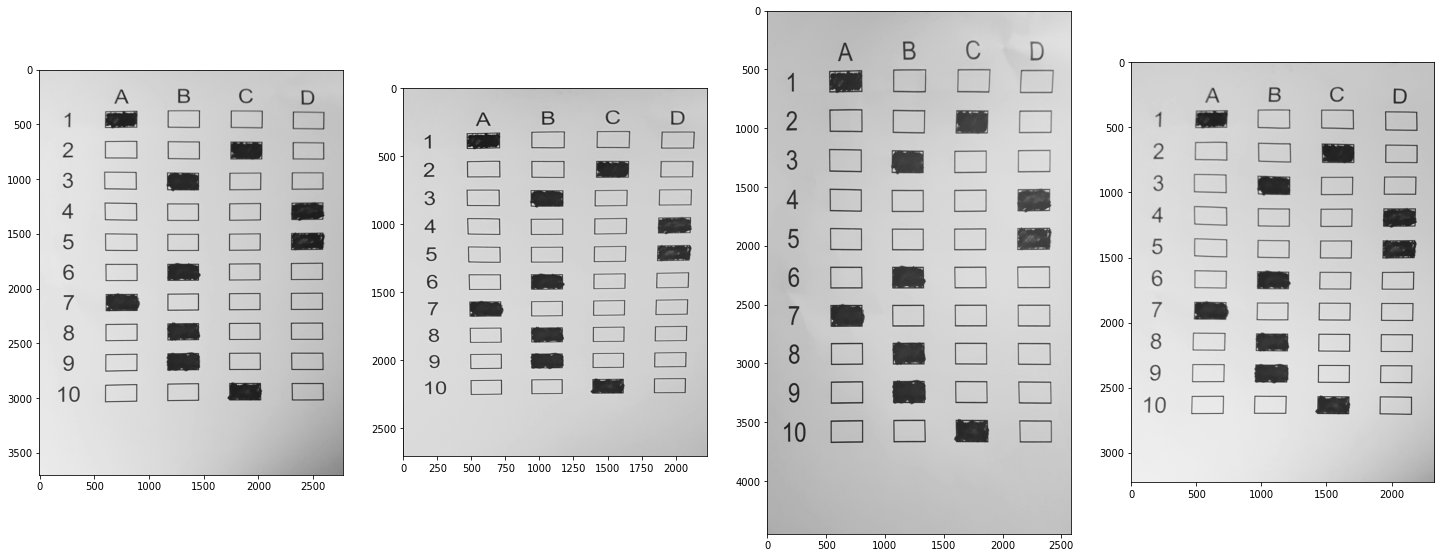

In [4]:
warp1 = four_point_transform(img1, np.array([[160, 500], [2750, 500], [2870, 4200], [100, 4200]]))
warp2 = four_point_transform(img2, np.array([[50, 1100], [1750, 550], [2900, 2950], [800, 3700]]))
warp3 = four_point_transform(img3, np.array([[350, 300], [2630, 900], [2870, 4200], [350, 4750]]))
warp4 = four_point_transform(img4, np.array([[50, 1630], [1450, 370], [2800, 3300], [650, 4200]]))

fig = plt.figure(figsize=(25, 10))
plt.subplot(141)
plt.imshow(warp1, cmap="gray")
plt.subplot(142)
plt.imshow(warp2, cmap="gray")
plt.subplot(143)
plt.imshow(warp3, cmap="gray")
plt.subplot(144)
plt.imshow(warp4, cmap="gray")
plt.show()

# Binarization

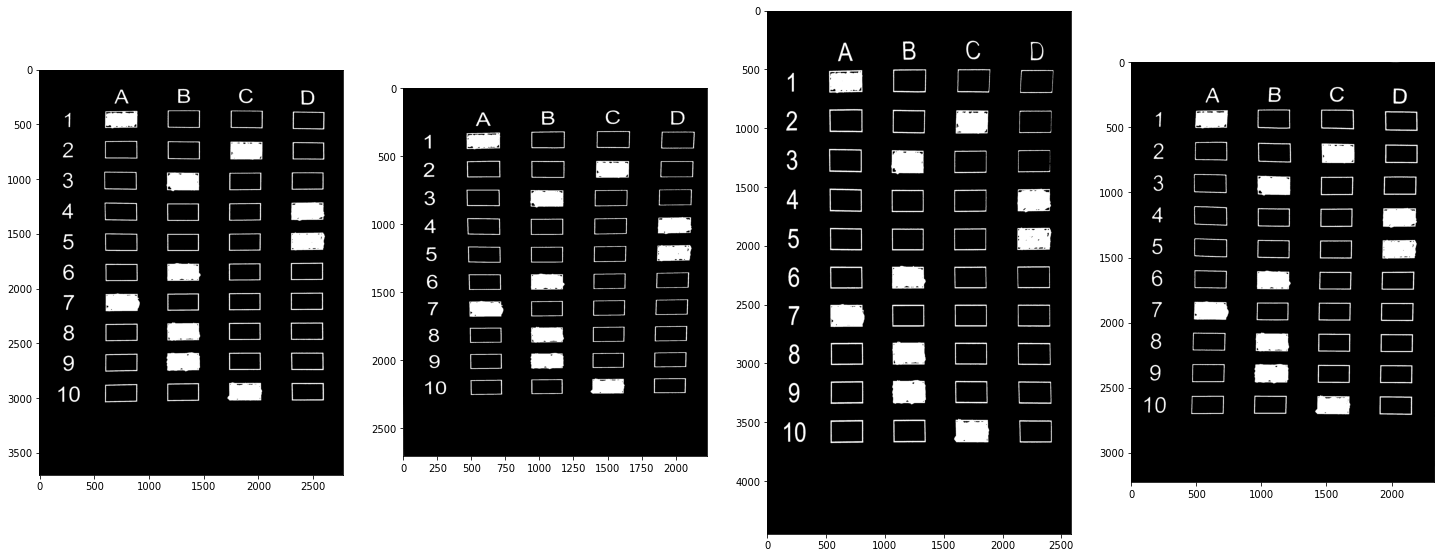

In [5]:
threshold = 130

thresh1 = cv2.threshold(warp1,threshold,255,cv2.THRESH_BINARY_INV)[1]
thresh2 = cv2.threshold(warp2,threshold,255,cv2.THRESH_BINARY_INV)[1]
thresh3 = cv2.threshold(warp3,threshold,255,cv2.THRESH_BINARY_INV)[1]
thresh4 = cv2.threshold(warp4,threshold,255,cv2.THRESH_BINARY_INV)[1]

fig = plt.figure(figsize=(25, 10))
plt.subplot(141)
plt.imshow(thresh1, cmap="gray")
plt.subplot(142)
plt.imshow(thresh2, cmap="gray")
plt.subplot(143)
plt.imshow(thresh3, cmap="gray")
plt.subplot(144)
plt.imshow(thresh4, cmap="gray")
plt.show()

In [6]:
for index, img in enumerate([thresh1, thresh2, thresh3, thresh4], start=1):
    print(f"\nImage {index} answers")
    answers = detectAnswers(img)
    pp = pprint.PrettyPrinter(depth=4)
    pp.pprint(answers)


Image 1 answers
{1: ['A'],
 2: ['C'],
 3: ['B'],
 4: ['D'],
 5: ['D'],
 6: ['B'],
 7: ['A'],
 8: ['B'],
 9: ['B'],
 10: ['C']}

Image 2 answers
{1: ['A'],
 2: ['C'],
 3: ['B'],
 4: ['D'],
 5: ['D'],
 6: ['B'],
 7: ['A'],
 8: ['B'],
 9: ['B'],
 10: ['C']}

Image 3 answers
{1: ['A'],
 2: ['C'],
 3: ['B'],
 4: ['D'],
 5: ['D'],
 6: ['B'],
 7: ['A'],
 8: ['B'],
 9: ['B'],
 10: ['C']}

Image 4 answers
{1: ['A'],
 2: ['C'],
 3: ['B'],
 4: ['D'],
 5: ['D'],
 6: ['B'],
 7: ['A'],
 8: ['B'],
 9: ['B'],
 10: ['C']}


In [7]:
img1 = cv2.imread("20220421_152418_kopia.jpg", 0)
img2 = cv2.imread("20220421_152433_kopia.jpg", 0)



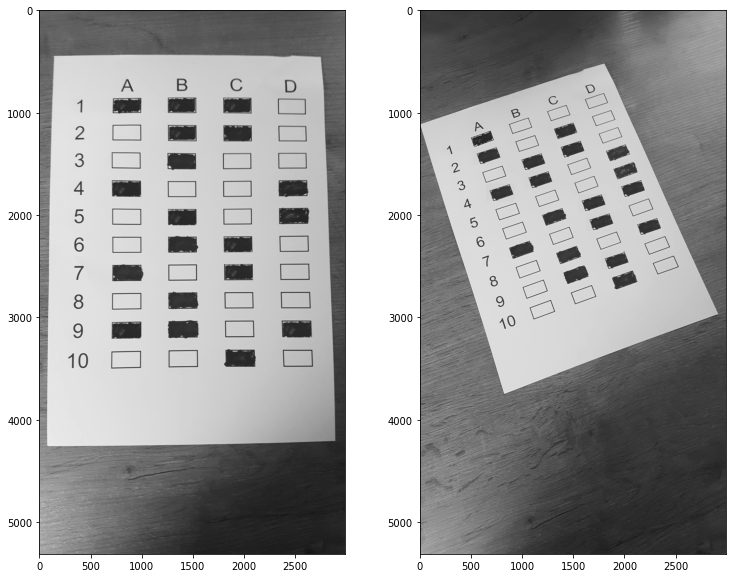

In [8]:
fig = plt.figure(figsize=(12.5, 10))
plt.subplot(121)
plt.imshow(img1, cmap="gray")
plt.subplot(122)
plt.imshow(img2, cmap="gray")
plt.show()

# Transformation

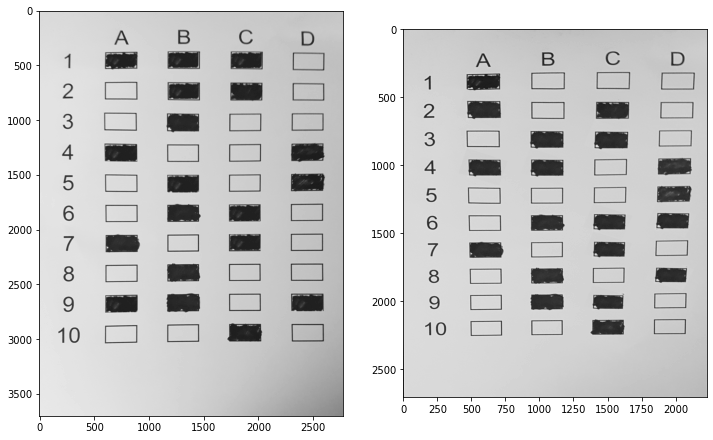

In [9]:
warp1 = four_point_transform(img1, np.array([[160, 500], [2750, 500], [2870, 4200], [100, 4200]]))
warp2 = four_point_transform(img2, np.array([[50, 1100], [1750, 550], [2900, 2950], [800, 3700]]))


fig = plt.figure(figsize=(25, 10))
plt.subplot(141)
plt.imshow(warp1, cmap="gray")
plt.subplot(142)
plt.imshow(warp2, cmap="gray")
plt.show()

# Binarization

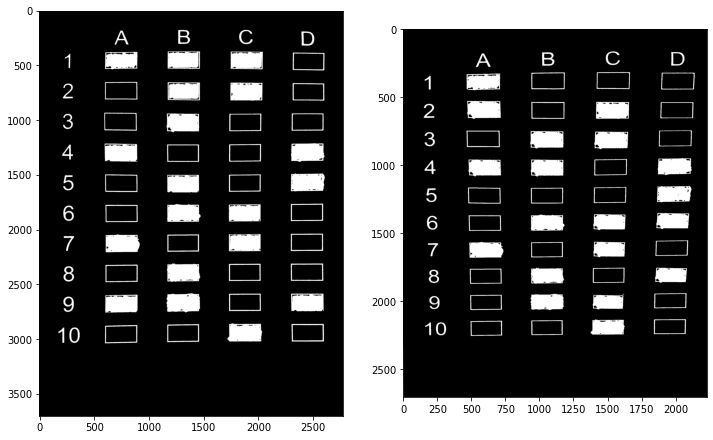

In [10]:
threshold = 130

thresh1 = cv2.threshold(warp1,threshold,255,cv2.THRESH_BINARY_INV)[1]
thresh2 = cv2.threshold(warp2,threshold,255,cv2.THRESH_BINARY_INV)[1]

fig = plt.figure(figsize=(25, 10))
plt.subplot(141)
plt.imshow(thresh1, cmap="gray")
plt.subplot(142)
plt.imshow(thresh2, cmap="gray")
plt.show()

In [11]:
for index, img in enumerate([thresh1, thresh2], start=1):
    print(f"\nImage {index} answers")
    answers = detectAnswers(img)
    pp = pprint.PrettyPrinter(depth=4)
    pp.pprint(answers)


Image 1 answers
{1: ['A', 'B', 'C'],
 2: ['B', 'C'],
 3: ['B'],
 4: ['A', 'D'],
 5: ['B', 'D'],
 6: ['B', 'C'],
 7: ['A', 'C'],
 8: ['B'],
 9: ['A', 'B', 'D'],
 10: ['C']}

Image 2 answers
{1: ['A'],
 2: ['A', 'C'],
 3: ['B', 'C'],
 4: ['A', 'B', 'D'],
 5: ['D'],
 6: ['B', 'C', 'D'],
 7: ['A', 'C'],
 8: ['B', 'D'],
 9: ['B', 'C'],
 10: ['C']}
